In [3]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00


In [4]:
import einops
from tqdm.notebook import tqdm

from torchsummary import summary

import time

import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop

In [6]:

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

patch_size = 16
latent_size = 768
n_channels = 3
num_heads = 12
num_encoders = 12
dropout = 0.1
num_classes = 10
size = 224

epochs = 30
base_lr = 10e-3
weight_decay = 0.03
batch_size = 4

cuda:0


In [6]:
transform_training_data = Compose(
    [RandomCrop(32, padding=4), Resize((224)), RandomHorizontalFlip(), ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_data = torchvision.datasets.CIFAR10(
    root='/home/achalhoub/Desktop/ViT_CIFAR10_data', train=True, download=True, transform=transform_training_data)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49506934.73it/s]


Extracting /home/achalhoub/Desktop/ViT_CIFAR10_data/cifar-10-python.tar.gz to /home/achalhoub/Desktop/ViT_CIFAR10_data


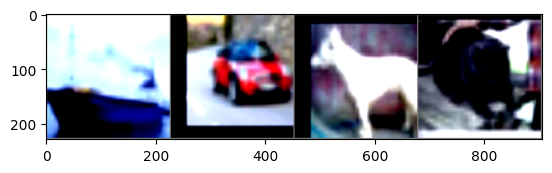

ship  car   dog   cat  


In [9]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)


        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


    def forward(self, input_data):

        input_data = input_data.to(self.device)


        patches = einops.rearrange(
            input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape


        linear_projection = torch.cat((self.class_token, linear_projection), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)


        linear_projection += pos_embed

        return linear_projection


In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout


        self.norm = nn.LayerNorm(self.latent_size)


        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)


        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):


        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]


        first_added_output = attention_output + embedded_patches


        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        return ff_output + first_added_output

In [10]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        # Create a stack of encoder layers
        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):


        enc_output = self.embedding(test_input)


        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        cls_token_embedding = enc_output[:, 0]

        return self.MLP_head(cls_token_embedding)

In [11]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)


optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LinearLR(optimizer)

TypeError: ignored

In [14]:
def main():
    model.train().to(device)

    for epoch in tqdm(range(epochs), total=epochs):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):

            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 200 == 0:
                print('Batch {} epoch {} has loss = {}'.format(batch_idx, epoch, running_loss/200))
                running_loss = 0

        scheduler.step()


In [15]:
main()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Batch 0 epoch 0 has loss = 0.012290771007537843
Batch 200 epoch 0 has loss = 3.5112502110004424
Batch 400 epoch 0 has loss = 2.3394980412721633
Batch 600 epoch 0 has loss = 2.308505367040634
Batch 800 epoch 0 has loss = 2.3039539456367493
Batch 1000 epoch 0 has loss = 2.3031847465038298
Batch 1200 epoch 0 has loss = 2.305007743835449
Batch 1400 epoch 0 has loss = 2.304039740562439
Batch 1600 epoch 0 has loss = 2.3046200704574584
Batch 1800 epoch 0 has loss = 2.301165565252304
Batch 2000 epoch 0 has loss = 2.302417356967926
Batch 2200 epoch 0 has loss = 2.302152647972107


KeyboardInterrupt: ignored